# Data Quality Issues - Exploration

This notebook demonstrates the 5 types of data quality issues that our system detects:
1. Schema Drift
2. Distribution Shift
3. Missing Data Patterns
4. Outliers
5. Type Mismatches

In [1]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from src.data.bad_data_generator import BadDataGenerator
from src.profilers.spark_profiler import SparkDataProfiler

sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)

gen = BadDataGenerator()
profiler = SparkDataProfiler()

26/02/06 15:53:02 WARN Utils: Your hostname, Siddharths-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 10.0.0.250 instead (on interface en0)
26/02/06 15:53:02 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/02/06 15:53:03 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## 1. Clean Dataset (Baseline)

First, let's look at a clean dataset with no quality issues.

In [2]:
# Generate clean data
clean_df = gen.generate_clean_dataset(n_rows=5000)

print(f"Shape: {clean_df.shape}")
print(f"\nColumns: {clean_df.columns.tolist()}")
print(f"\nData types:\n{clean_df.dtypes}")
print(f"\nMissing values:\n{clean_df.isnull().sum()}")

clean_df.head(10)

Shape: (5000, 10)

Columns: ['id', 'timestamp', 'user_id', 'name', 'email', 'age', 'salary', 'department', 'experience_years', 'performance_score']

Data types:
id                            int64
timestamp            datetime64[ns]
user_id                      object
name                         object
email                        object
age                           int64
salary                      float64
department                   object
experience_years              int64
performance_score           float64
dtype: object

Missing values:
id                   0
timestamp            0
user_id              0
name                 0
email                0
age                  0
salary               0
department           0
experience_years     0
performance_score    0
dtype: int64


,id,timestamp,user_id,name,email,age,salary,department,experience_years,performance_score
0,0,2025-03-16 15:53:04.484272,bdd640fb-0667-4ad1-9c80-317fa3b1799d,Sue Warner,thompsonzachary@example.org,56,29609.756884,Finance,20,3.261541
1,1,2025-12-11 15:53:04.484342,23b8c1e9-3924-46de-beb1-3b9046685257,Amanda Zavala,sconway@example.org,69,99676.990895,Engineering,24,1.384304
2,2,2026-01-25 15:53:04.484349,bd9c66b3-ad3c-4d6d-9a3d-1fa7bc8960a9,Linda Salazar,phillipsrichard@example.org,46,100510.223630,Engineering,3,4.337800
3,3,2025-09-19 15:53:04.484352,972a8469-1641-4f82-8b9d-2434e465e150,Juan Potts,christopherandrade@example.com,32,87778.927059,Marketing,2,4.010075
4,4,2025-10-04 15:53:04.484354,17fc695a-07a0-4a6e-8822-e8f36c031199,Andrew Johnson,james01@example.com,60,88193.188305,Engineering,16,2.842037
5,5,2025-10-15 15:53:04.484357,9a1de644-815e-46d1-bb8f-aa1837f8a88b,Marie Reynolds,benjaminbrown@example.com,25,93667.276287,Sales,29,2.716843
6,6,2025-11-27 15:53:04.484359,b74d0fb1-32e7-4629-8fad-c1a606cb0fb3,Samuel Mata,alex78@example.org,78,77642.451933,Engineering,1,4.589356
7,7,2025-12-16 15:53:04.484361,6b65a6a4-8b81-48f6-b38a-088ca65ed389,Anthony Ayala,englishchristina@example.net,38,67529.076006,HR,18,2.153833
8,8,2025-02-25 15:53:04.484363,47378190-96da-4dac-b2ff-5d2a386ecbe0,Kimberly Dalton,jward@example.com,56,98027.155387,Marketing,19,1.996080
9,9,2025-05-03 15:53:04.484365,c241330b-01a9-471f-9e8a-774bcf36d58b,Nancy Tran,luis66@example.org,75,103109.403183,HR,22,4.756790


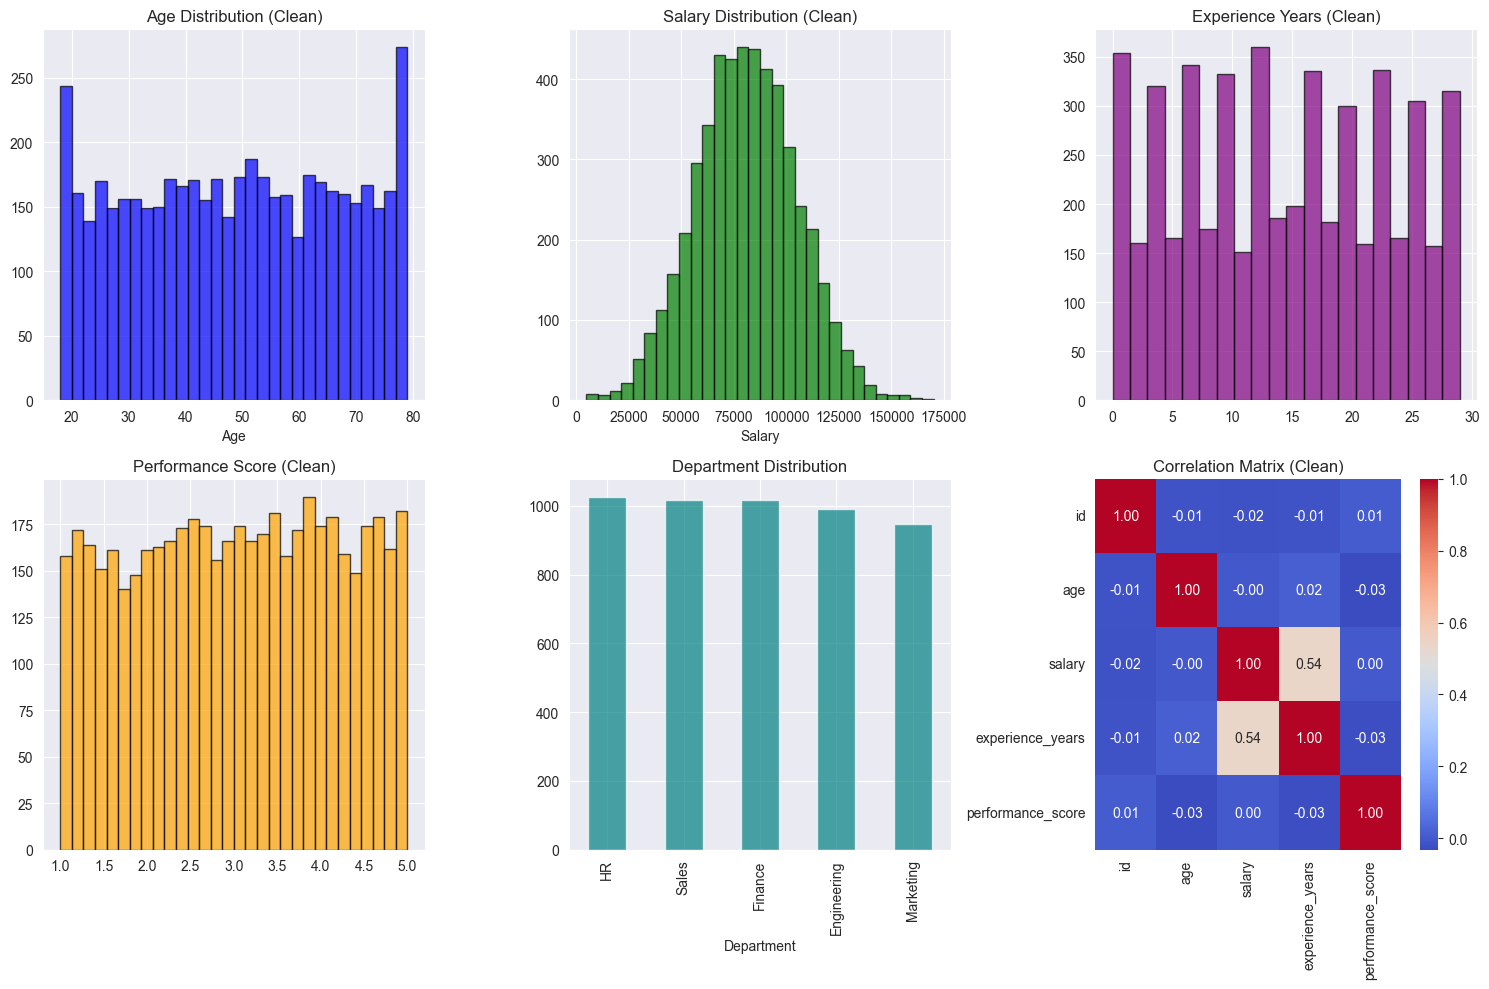

In [3]:
# Visualize clean data distributions
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Age distribution
axes[0, 0].hist(clean_df['age'], bins=30, color='blue', alpha=0.7, edgecolor='black')
axes[0, 0].set_title('Age Distribution (Clean)')
axes[0, 0].set_xlabel('Age')

# Salary distribution
axes[0, 1].hist(clean_df['salary'], bins=30, color='green', alpha=0.7, edgecolor='black')
axes[0, 1].set_title('Salary Distribution (Clean)')
axes[0, 1].set_xlabel('Salary')

# Experience years distribution
axes[0, 2].hist(clean_df['experience_years'], bins=20, color='purple', alpha=0.7, edgecolor='black')
axes[0, 2].set_title('Experience Years (Clean)')

# Performance score distribution
axes[1, 0].hist(clean_df['performance_score'], bins=30, color='orange', alpha=0.7, edgecolor='black')
axes[1, 0].set_title('Performance Score (Clean)')

# Department distribution
clean_df['department'].value_counts().plot(kind='bar', ax=axes[1, 1], color='teal', alpha=0.7)
axes[1, 1].set_title('Department Distribution')
axes[1, 1].set_xlabel('Department')

# Correlation heatmap
numeric_cols = clean_df.select_dtypes(include=[np.number]).columns
corr = clean_df[numeric_cols].corr()
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', ax=axes[1, 2], cbar=True)
axes[1, 2].set_title('Correlation Matrix (Clean)')

plt.tight_layout()
plt.show()

## 2. Schema Drift

Schema drift occurs when columns are added, removed, or change types.

In [4]:
# Generate data with schema drift
schema_drift_df, metadata = gen.generate_quality_issue_dataset(n_rows=5000, issue_type='schema_drift')

print(f"Original columns: {clean_df.columns.tolist()}")
print(f"\nNew columns: {schema_drift_df.columns.tolist()}")
print(f"\nAdded columns: {set(schema_drift_df.columns) - set(clean_df.columns)}")
print(f"\nMetadata shape: {metadata.shape}")

schema_drift_df.head()

Original columns: ['id', 'timestamp', 'user_id', 'name', 'email', 'age', 'salary', 'department', 'experience_years', 'performance_score']

New columns: ['id', 'timestamp', 'user_id', 'name', 'email', 'age', 'salary', 'department', 'experience_years', 'performance_score']

Added columns: set()

Metadata shape: (5000, 11)


,id,timestamp,user_id,name,email,age,salary,department,experience_years,performance_score
0,0,2025-03-04 15:53:11.000986,cb925e92-d9f7-4788-8d61-d4c5a6521543,Victoria Butler,fmyers@example.com,59,79166.103534,HR,22,1.836702
1,1,2025-02-25 15:53:11.001049,54c26dd3-b895-4915-9b0f-3227698a7ada,Derek Cook,cindycampbell@example.org,45,56104.136396,Marketing,1,4.526826
2,2,2025-03-15 15:53:11.001053,174d0bfc-e720-4ea1-a461-a17f95b089de,Jared Arnold,elliskendra@example.org,30,85210.033796,Marketing,26,1.236401
3,3,2025-07-24 15:53:11.001055,512b171b-9676-48a4-87c8-604cb510ffa9,Todd Jones,david57@example.com,37,61040.167589,Sales,10,1.907953
4,4,2025-11-22 15:53:11.001058,ceecd82b-81d4-486f-8a7a-59d062103666,Elizabeth West,callahankristen@example.org,69,98320.375373,Sales,27,2.405001


## 3. Distribution Shift

Distribution shift occurs when the statistical properties of data change over time.

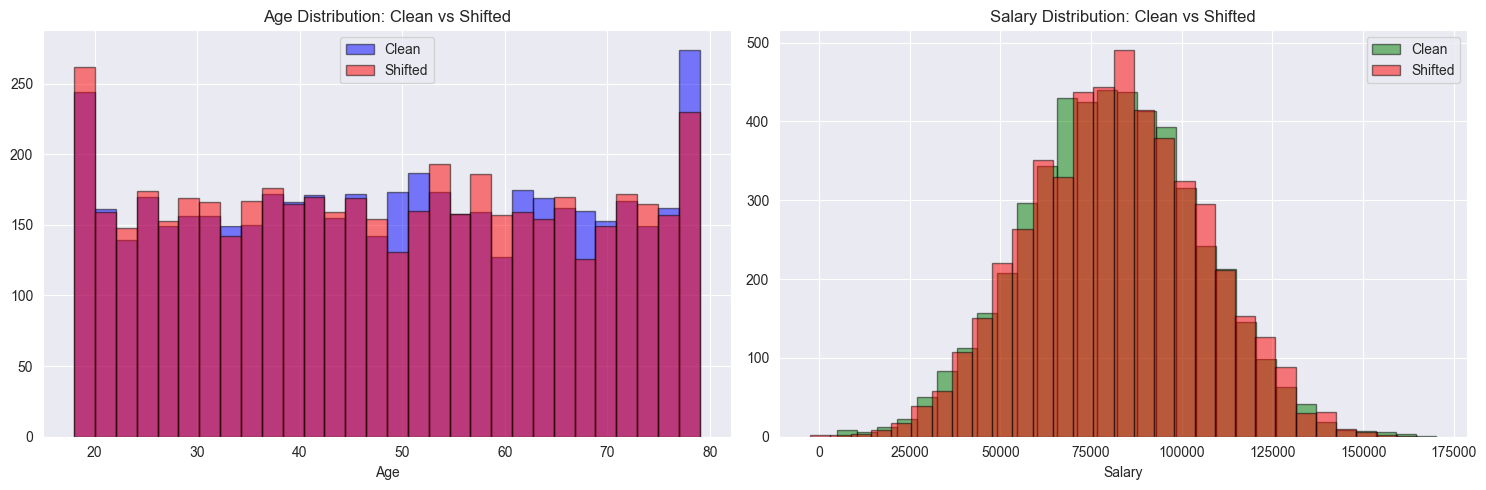


Clean age: mean=48.81, std=17.91
Shifted age: mean=48.23, std=17.84

Clean salary: mean=80972.29, std=23919.19
Shifted salary: mean=81896.03, std=23962.88


In [5]:
# Generate data with distribution shift
dist_shift_df, metadata = gen.generate_quality_issue_dataset(n_rows=5000, issue_type='distribution_shift')

# Compare distributions
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Age distribution comparison
axes[0].hist(clean_df['age'], bins=30, alpha=0.5, label='Clean', color='blue', edgecolor='black')
axes[0].hist(dist_shift_df['age'], bins=30, alpha=0.5, label='Shifted', color='red', edgecolor='black')
axes[0].set_title('Age Distribution: Clean vs Shifted')
axes[0].set_xlabel('Age')
axes[0].legend()

# Salary distribution comparison
axes[1].hist(clean_df['salary'], bins=30, alpha=0.5, label='Clean', color='green', edgecolor='black')
axes[1].hist(dist_shift_df['salary'], bins=30, alpha=0.5, label='Shifted', color='red', edgecolor='black')
axes[1].set_title('Salary Distribution: Clean vs Shifted')
axes[1].set_xlabel('Salary')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"\nClean age: mean={clean_df['age'].mean():.2f}, std={clean_df['age'].std():.2f}")
print(f"Shifted age: mean={dist_shift_df['age'].mean():.2f}, std={dist_shift_df['age'].std():.2f}")
print(f"\nClean salary: mean={clean_df['salary'].mean():.2f}, std={clean_df['salary'].std():.2f}")
print(f"Shifted salary: mean={dist_shift_df['salary'].mean():.2f}, std={dist_shift_df['salary'].std():.2f}")

## 4. Missing Data Patterns

Missing value counts:
id                   0
timestamp            0
user_id              0
name                 0
email                0
age                  0
salary               0
department           0
experience_years     0
performance_score    0
dtype: int64

Missing percentage: 0.00%


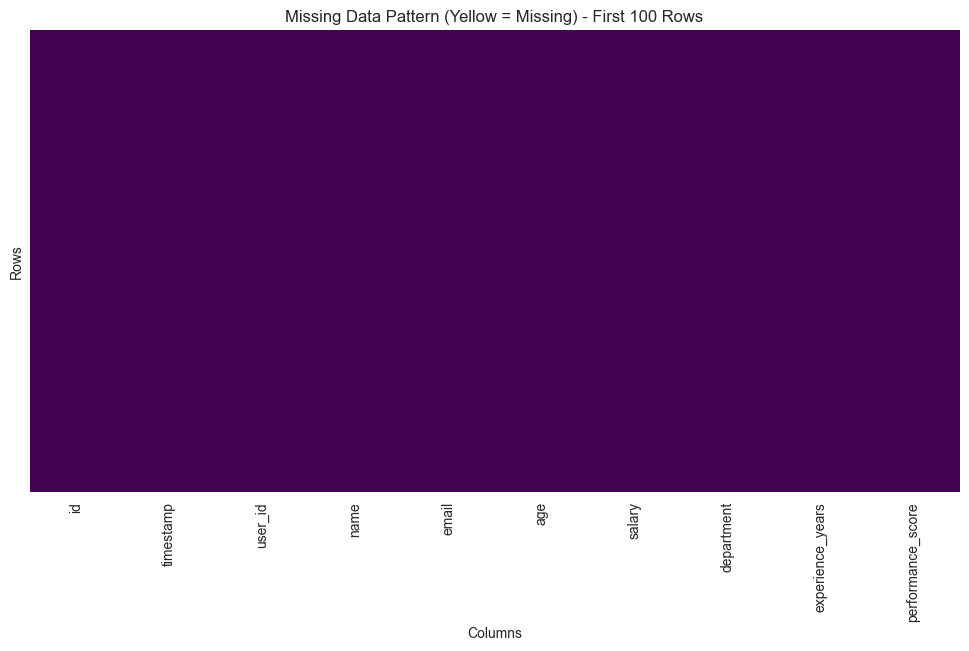

In [6]:
# Generate data with missing values
missing_df, metadata = gen.generate_quality_issue_dataset(n_rows=5000, issue_type='missing_data')

print("Missing value counts:")
print(missing_df.isnull().sum())
print(f"\nMissing percentage: {(missing_df.isnull().sum().sum() / (missing_df.shape[0] * missing_df.shape[1]) * 100):.2f}%")

# Visualize missing data pattern
plt.figure(figsize=(12, 6))
sns.heatmap(missing_df.head(100).isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title('Missing Data Pattern (Yellow = Missing) - First 100 Rows')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.show()

## 5. Outliers

/var/folders/1r/_lhwyjcx6s9781gnlb2xyg9w0000gn/T/ipykernel_62637/1138881417.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0].boxplot([clean_df['salary'], outlier_df['salary']], labels=['Clean', 'With Outliers'])


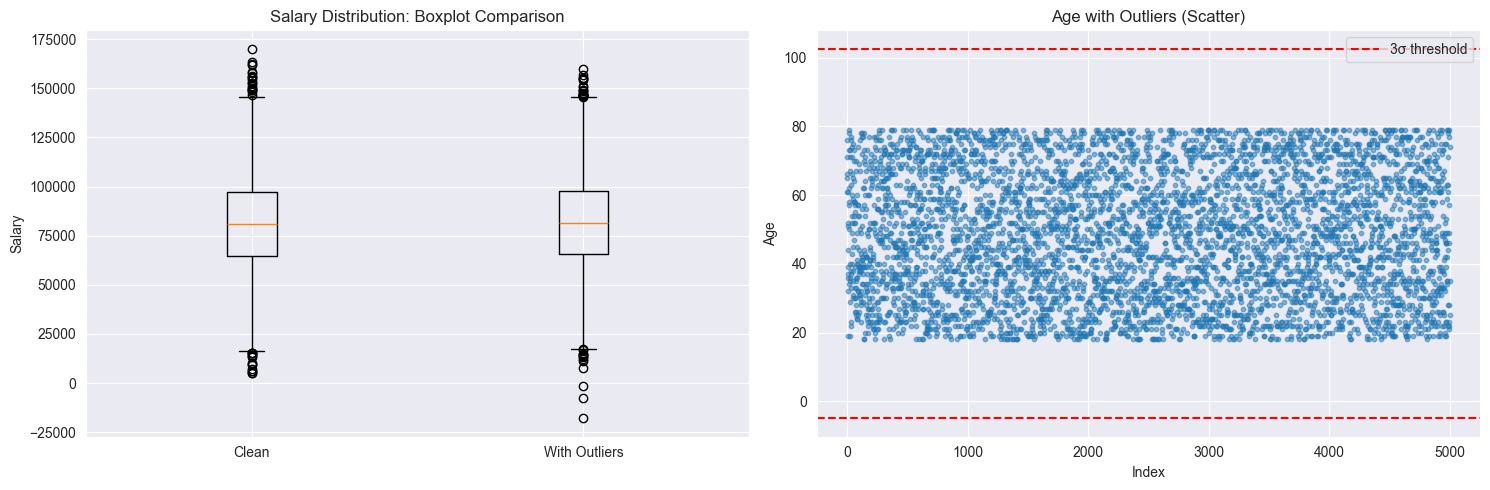


Clean salary: mean=80972.29, std=23919.19
With outliers: mean=81477.23, std=23762.93


In [7]:
# Generate data with outliers
outlier_df, metadata = gen.generate_quality_issue_dataset(n_rows=5000, issue_type='outlier')

# Compare distributions
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Salary boxplot comparison
axes[0].boxplot([clean_df['salary'], outlier_df['salary']], labels=['Clean', 'With Outliers'])
axes[0].set_title('Salary Distribution: Boxplot Comparison')
axes[0].set_ylabel('Salary')

# Age scatter plot
axes[1].scatter(outlier_df.index, outlier_df['age'], alpha=0.5, s=10)
axes[1].set_title('Age with Outliers (Scatter)')
axes[1].set_xlabel('Index')
axes[1].set_ylabel('Age')
axes[1].axhline(y=clean_df['age'].mean() + 3*clean_df['age'].std(), color='r', linestyle='--', label='3σ threshold')
axes[1].axhline(y=clean_df['age'].mean() - 3*clean_df['age'].std(), color='r', linestyle='--')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"\nClean salary: mean={clean_df['salary'].mean():.2f}, std={clean_df['salary'].std():.2f}")
print(f"With outliers: mean={outlier_df['salary'].mean():.2f}, std={outlier_df['salary'].std():.2f}")

## 6. Type Mismatches

In [8]:
# Generate data with type mismatches
type_mismatch_df, metadata = gen.generate_quality_issue_dataset(n_rows=5000, issue_type='type_mismatch')

print("Data types in clean data:")
print(clean_df.dtypes)
print("\nData types with mismatches:")
print(type_mismatch_df.dtypes)

print("\nSample values showing type issues:")
type_mismatch_df.head(10)

Data types in clean data:
id                            int64
timestamp            datetime64[ns]
user_id                      object
name                         object
email                        object
age                           int64
salary                      float64
department                   object
experience_years              int64
performance_score           float64
dtype: object

Data types with mismatches:
id                            int64
timestamp            datetime64[ns]
user_id                      object
name                         object
email                        object
age                           int64
salary                      float64
department                   object
experience_years              int64
performance_score           float64
dtype: object

Sample values showing type issues:


/Users/siddthir/Documents/data-quality-autohealer/notebooks/../src/data/bad_data_generator.py:204: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'unknown' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[error_indices, 'age'] = 'unknown'


,id,timestamp,user_id,name,email,age,salary,department,experience_years,performance_score
0,0,2025-09-05 15:53:30.346505,b4bfe837-b186-4297-aca2-503b0b3a87b5,Tammie Martin,xmathis@example.com,79,84693.731118,Sales,13,2.349054
1,1,2025-08-28 15:53:30.346613,9fc0f0b0-1277-4d19-af61-6b4d98ad204a,Timothy York,alexandramathis@example.org,24,95484.039045,Engineering,21,2.223013
2,2,2025-09-01 15:53:30.346617,320a7be9-4d11-4e96-bdf9-a4698273f90d,Austin Schneider,michelle00@example.com,68,61387.049429,Engineering,5,1.188371
3,3,2025-10-20 15:53:30.346620,30e2e404-4cc9-4de0-91e9-a00ad0cb827f,Lisa Johnson,dana64@example.net,33,84109.447315,Engineering,8,1.842855
4,4,2026-01-09 15:53:30.346622,6a9c261a-30e6-4a9a-9795-35d715517d75,John Hampton,benjamin02@example.org,45,84798.999573,Marketing,3,3.613447
5,5,2025-06-20 15:53:30.346624,5f2f9e26-9d2f-4e6f-8cbc-43810d0647e1,Jesse White,freed@example.com,68,103999.418953,Engineering,18,1.528083
6,6,2025-04-22 15:53:30.346626,be88226a-8fc0-4205-b055-1a628cfa0ee3,Alicia Ortega,valerie10@example.com,63,81634.229746,Sales,15,1.624695
7,7,2025-07-10 15:53:30.346628,0fa808a2-1373-476f-8655-451fc5c5952e,Tina Gonzalez,stephensoncarol@example.org,67,49435.362964,Marketing,7,3.790470
8,8,2025-10-17 15:53:30.346630,241c65e2-f1ec-4913-a8bd-1cc949c4ba7b,Duane Walker,uterry@example.net,73,71648.637549,Marketing,25,1.653357
9,9,2025-03-07 15:53:30.346632,e7de9dee-9fea-4351-bfad-b0ec8d91f0ba,Katie Hunter,lperez@example.net,59,104747.397611,Finance,17,1.901460


## Summary

We've explored all 5 types of data quality issues that our auto-healing system detects and fixes.

Next notebook: Training the ML detectors and evaluating their performance.